# **A Deep Dive Into Multi-Head Attention And PyTorch Buffers**

## **Comparisons of Efficient Multi-Head Attention Implementations**

In [1]:
import torch
import torch.nn as nn

torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch version: {torch.__version__}")

batch_size = 8
context_length = 1024
embed_dim = 768
embeddings = torch.randn((batch_size, context_length, embed_dim), device=device)

PyTorch version: 2.7.0+cu126


### **1. CausalAttention MHA Wrapper**

In [44]:
class CausalAttention(nn.Module):
    
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask",
                             torch.triu(torch.ones(context_length, context_length), diagonal=1))
        
    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        attn_scores = queries @ keys.transpose(1, 2)
        attn_scores.masked_fill(
            self.mask.bool()[:num_tokens, :num_tokens],
            -torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        context_vec = attn_weights @ values
        return context_vec
    
class MHA_Wrapper(nn.Module):
    
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias)
             for _ in range(num_heads)])
        self.out_proj = nn.Linear(d_out*num_heads, d_out*num_heads)
        
    def forward(self, x):
        context_vec = torch.cat([head(x) for head in self.heads], dim=-1)
        return self.out_proj(context_vec)

In [45]:
mha_wrapper = MHA_Wrapper(
    d_in=embed_dim,
    d_out=embed_dim//12,
    context_length=context_length,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)


In [46]:
%time out = mha_wrapper(embeddings)
out.shape

CPU times: user 200 ms, sys: 804 μs, total: 201 ms
Wall time: 195 ms


torch.Size([8, 1024, 768])

### **2. Multi-Head Attention With Split Weights**

In [9]:
class MHA(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        
        self.d_out = d_out
        self.num_heads = num_heads
        # Reduce projection dim to match desired output dim
        self.head_dim = d_out // num_heads
        
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))
        
    def forward(self, x):
        b, num_tokens, d_in = x.shape
        
        keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        # Implicitly split the matrix by adding `num-heads` dim
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        
        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)
        
        # Scaled dot product attention with causal mask. Dot product for each head
        attn_scores = queries @ keys.transpose(2, 3) 
        
        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec
        

In [10]:
mha = MHA(
    d_in=embed_dim,
    d_out= embed_dim,
    context_length=context_length,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

In [11]:
%time out = mha(embeddings)
print(out.shape)

CPU times: user 105 ms, sys: 8.17 ms, total: 113 ms
Wall time: 119 ms
torch.Size([8, 1024, 768])


### **3. Alternative MHA With Combined Weights**

The code for the `MultiHeadAttentionCombinedQKV` class below is based on code that was shared by [Rayed Bin Wahed](https://github.com/rasbt/LLMs-from-scratch/discussions/51).

The difference between `MultiHeadAttentionCombinedQKV` class and the `MHA` class in the previous section is the use of a single weight matrix instead of separate weight matrices for the prior.

In [12]:
class MultiHeadAttentionCombinedQKV(nn.Module):
    def __init__(self, d_in, d_out, num_heads, context_length, dropout=0.0, qkv_bias=False):
        super().__init__()

        assert d_out % num_heads == 0, "embed_dim is indivisible by num_heads"

        self.num_heads = num_heads
        self.context_length = context_length
        self.head_dim = d_out // num_heads

        self.qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias) # Key change
        self.proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)

        self.register_buffer(
            "mask", torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )
        
    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape
        
        # (b, num_tokens , embed_dim) --> (b, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)
        
        # (b, num_tokens, 3 * embed_dim) --> (b, num_tokens, 3, num_heads, head_dim)
        qkv = qkv.view(batch_size, num_tokens, 3, self.num_heads, self.head_dim)
        
        # (b - num_tokens, 3, num_heads, head_dim) --> (3, b, num_heads, num_tokens, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        
        # (3, b, num_heads, num_tokens, head_dim) -> 3 times (b, num_head, num_tokens, head_dim)
        queries, keys, values = qkv.unbind(0)
        
        # (b, num_heads, num_tokens, head_dim) --> (b, num_heads, num_tokens, num_tokens)
        attn_scores = queries @ keys.transpose(-2, -1)
        attn_scores = attn_scores.masked_fill(
            self.mask.bool()[:num_tokens, :num_tokens],
            -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # (b, num_heads, num_tokens, num_tokens) --> (b, num_heads, num_tokens, head_dim)
        context_vec = attn_weights @ values
        
        # (b, num_heads, num_tokens, head_dim) --> (b, num_heads, num_heads, head_dim)
        context_vec = context_vec.transpose(1, 2)
        
        # (b, num_heads, num_heads, head_dim) --> (b, num_tokens, embed_dim)
        context_vec = context_vec.contiguous().view(batch_size, num_tokens, embed_dim)
        
        context_vec = self.proj(context_vec)
        return context_vec

In [13]:
mha_combined_qkv = MultiHeadAttentionCombinedQKV(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_length,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

In [14]:
%time out = mha_combined_qkv(embeddings)

CPU times: user 2.12 ms, sys: 366 μs, total: 2.48 ms
Wall time: 2.87 ms


In [15]:
out.shape

torch.Size([8, 1024, 768])

### **4. Implementing MHA with Einsum**

Implementations of MHA using `einsum` are often faster than base implementations due to reduced tensor manipulation overhead, optimized batched computations and kernel fusion opportunities. Specifically, PyTorch’s einsum leverages optimized backends (e.g., NVIDIA’s cuTENSOR) for specific tensor contractions, outperforming naive PyTorch operations.

In [16]:
import math

class MHAEinsum(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        
        # Parameters for Q, K, V
        self.W_query = nn.Parameter(torch.randn(d_out, d_in))
        self.W_key = nn.Parameter(torch.randn(d_out, d_in))
        self.W_value = nn.Parameter(torch.randn(d_out, d_in))
        
        if qkv_bias:
            self.bias_q = nn.Parameter(torch.zeros(d_out))
            self.bias_k = nn.Parameter(torch.zeros(d_out))
            self.bias_v = nn.Parameter(torch.zeros(d_out))
        else:
            self.register_parameter("bias_q", None)
            self.register_parameter("bias_k", None)
            self.register_parameter("bias_v", None)
            
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask",
                             torch.triu(torch.ones(context_length, context_length), diagonal=1))
        
        # Initialize parameters
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.W_query, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.W_key, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.W_value, a=math.sqrt(5))
        
        if self.bias_q is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_query)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias_q, -bound, bound)
            nn.init.uniform_(self.bias_k, -bound, bound)
            nn.init.uniform_(self.bias_v, -bound, bound)
            
    def forward(self, x):
        b, n, _ = x.shape
        
        # Calculate Q, K, V using einsum, beginning with linear transforms
        Q = torch.einsum("bnd,di->bni", x, self.W_query)
        K = torch.einsum("bnd,di->bni", x, self.W_key)
        V = torch.einsum("bnd,di->bni", x, self.W_value)
        
        # Add biases if they are used
        if self.bias_q is not None:
            Q += self.bias_q
            K += self.bias_k
            V += self.bias_v
            
        # Reshape for multi-head attention
        Q = Q.view(b, n, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(b, n, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(b, n, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Scaled dot-product attention
        scores = torch.einsum("bhnd,bhmd->bhnm", Q, K) / (self.head_dim ** 0.5)
        
        # Apply mask
        mask = self.mask[:n, :n].unsqueeze(0).unsqueeze(1).expand(b, self.num_heads, n, n) 
        scores = scores.masked_fill(mask.bool(), -torch.inf)
        
        # Softmax and dropout
        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # Aggregate the attended context vectors
        context_vec = torch.einsum("bhnm, bhmd->bhnd", attn_weights, V)
        
        # Combine heads and project the output
        context_vec = context_vec.transpose(1, 2).reshape(b, n, self.d_out)
        context_vec = self.out_proj(context_vec)
        
        return context_vec

In [17]:
mha_einsum = MHAEinsum(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_length,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

In [18]:
%time out = mha_einsum(embeddings)

CPU times: user 0 ns, sys: 8.18 ms, total: 8.18 ms
Wall time: 14.6 ms


In [24]:
out.shape

torch.Size([8, 1024, 768])

### **5. MHA With PyTorch's Scaled Dot Product Attention and FlashAttention**

In [19]:
# Using PyTorch's scaled_dot_product_attention function which implements
# a memory optimized version of self-attention called Flash Attention
class MHAPyTorchScaledDotProduct(nn.Module):
    def __init__(self, d_in, d_out, num_heads, context_length, dropout=0.0, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "embed_dim is indivisible by num_heads"
        
        self.num_heads = num_heads
        self.context_length = context_length
        self.head_dim = d_out // num_heads
        self.d_out = d_out
        
        self.qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)
        self.proj = nn.Linear(d_out, d_out)
        self.dropout = dropout

    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape
        
        # (b, num_tokens, embed_dim) --> (b, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)
        
        # (b, num_tokens, 3 * embed_dim) --> (b, num_tokens, 3, num_heads, head_dim)
        qkv = qkv.view(batch_size, num_tokens, 3, self.num_heads, self.head_dim)
        
        # (b, num_tokens, 3, num_heads, head_dim) --> (3, b, num_heads, num_tokens, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        
        # (3, b, num_heads, num_tokens, head_dim) --> 3 times (b, num_heads, num_tokens, head_dim)
        queries, keys, values = qkv
        
        use_dropout = 0. if not self.training else self.dropout
        
        context_vec = nn.functional.scaled_dot_product_attention(
            queries, keys, values, attn_mask=None, dropout_p=use_dropout, is_causal=True)
        
        # Combine heads where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.transpose(1, 2).contiguous().view(batch_size, num_tokens, self.d_out)
        context_vec = self.proj(context_vec)
        return context_vec

In [20]:
mha_pytorch_scaled = MHAPyTorchScaledDotProduct(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_length,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

In [21]:
%time out = mha_pytorch_scaled(embeddings)

CPU times: user 4.55 ms, sys: 152 μs, total: 4.71 ms
Wall time: 8.97 ms


In [32]:
out.shape

torch.Size([8, 1024, 768])

### **6. PyTorch's Scaled Dot-Product Attention w/o FlashAttention** 

In [ ]:
# Compared to the above, we disable FlashAttention by passing an explicit
# causal mask

class MHASDPAWithoutFlash(nn.Module):
    def __init__(self, d_in, d_out, num_heads, context_length, dropout=0.0, qkv_bias=False):
        super().__init__()

        assert d_out % num_heads == 0, "embed_dim is indivisible by num_heads"

        self.num_heads = num_heads
        self.context_length = context_length
        self.head_dim = d_out // num_heads
        self.d_out = d_out

        self.qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)
        self.proj = nn.Linear(d_out, d_out)
        self.dropout = dropout
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1).bool())

    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape

        # (b, num_tokens, embed_dim) --> (b, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)

        # (b, num_tokens, 3 * embed_dim) --> (b, num_tokens, 3, num_heads, head_dim)
        qkv = qkv.view(batch_size, num_tokens, 3, self.num_heads, self.head_dim)

        # (b, num_tokens, 3, num_heads, head_dim) --> (3, b, num_heads, num_tokens, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)

        # (3, b, num_heads, num_tokens, head_dim) -> 3 times (b, num_heads, num_tokens, head_dim)
        queries, keys, values = qkv

        use_dropout = 0. if not self.training else self.dropout
        
        # Ensure attn_mask is compatible with expected shape and `batch_first=True`
        # Manual adjustment of num_heads is not necessary
        if self.context_length >= num_tokens:
            attn_mask = self.mask[:num_tokens, :num_tokens]
        else:
            attn_mask = self.mask[:self.context_length, :self.context_length]
        
        context_vec = nn.functional.scaled_dot_product_attention(
            queries, keys, values, attn_mask=attn_mask, dropout_p=use_dropout, is_causal=False)
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.transpose(1, 2).contiguous().view(batch_size, num_tokens, self.d_out)
        context_vec = self.proj(context_vec)
        
        return context_vec 

In [ ]:
mha_sdpa_no_flash = MHASDPAWithoutFlash(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_length,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

In [25]:
%time out = mha_sdpa_no_flash(embeddings)
print(out.shape)

CPU times: user 1.43 ms, sys: 0 ns, total: 1.43 ms
Wall time: 1.13 ms
torch.Size([8, 1024, 768])


### **7. PyTorch's Own `torch.nn.MultiheadAttention`**

This is the most straightforward approach to using MHA and includes numerous optimizations under the hood.

In [3]:
class MHAPyTorch(nn.Module):
    def __init__(self, d_in, d_out, num_heads, context_length, dropout=0.0, qkv_bias=False, need_weights=True):
        super().__init__()

        self.context_lenght = context_length
        self.mha = nn.MultiheadAttention(
            embed_dim=d_out,
            num_heads=num_heads,
            dropout=dropout,
            bias=qkv_bias,
            add_bias_kv=qkv_bias,
            batch_first=True,
            )
        self.need_weights = need_weights
        self.proj = nn.Linear(d_out, d_out)
        self.register_buffer("mask", 
                             torch.triu(torch.ones(context_length, context_length), diagonal=1).bool())
        
    def forward(self, x):
        batch_size, num_tokens, _ = x.shape

        # Ensure that attn_mask is compatible with expected shape and 'batch_first=True'
        # There is no need to manually adjust for num_heads
        if self.context_lenght >= num_tokens:
            attn_mask = self.mask[:num_tokens, :num_tokens]
        else:
            attn_mask = self.mask[:self.context_lenght, :self.context_lenght]
        
        # Broadcasting handled by attn_mask will handle batch_size dim implicitly
        attn_output, _ = self.mha(
            x, x, x, attn_mask=attn_mask, need_weights=self.need_weights
        )
        output = self.proj(attn_output)
        return output

In [7]:
mha_pytorch_default = MHAPyTorch(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_length,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

%time
out = mha_pytorch_default(embeddings)
print(out.shape)

CPU times: user 5 μs, sys: 0 ns, total: 5 μs
Wall time: 10 μs
torch.Size([8, 1024, 768])


Alternatively, the PyTorch version can also use `scaled dot product attention` by changing the `need_weights` parameter to `False`.

In [26]:
mha_pytorch_noweights = MHAPyTorch(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_length,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False,
    need_weights=False # set for scaled dot product attention
).to(device)

%time out = mha_pytorch_noweights(embeddings)
print(out.shape)

CPU times: user 50.7 ms, sys: 31.7 ms, total: 82.4 ms
Wall time: 2.34 ms
torch.Size([8, 1024, 768])


### **8. PyTorch's FlexAttention**

FlexAttention was [introduced by PyTorch developers](https://pytorch.org/blog/flexattention/) to address the "inflexibility" of prior fused attention implementations. The blog states:

> ...we introduce FlexAttention, a new PyTorch API.
>
>    1. We provide a flexible API that allows implementing many attention variants (including all the ones mentioned in the blog post so far) in a few lines of idiomatic PyTorch code.
>    2. We lower this into a fused FlashAttention kernel through torch.compile, generating a FlashAttention kernel that doesn’t materialize any extra memory and has performance competitive with handwritten ones.
>    3. We also automatically generate the backwards pass, leveraging PyTorch’s autograd machinery.
>    4. Finally, we can also take advantage of sparsity in the attention mask, resulting in significant improvements over standard attention implementations.

- FlexAttention doesn't support dropout as of right now (May-2025).

In [27]:
from packaging.version import parse as parse_version

def normalize_version(version):
    parsed_version = parse_version(version)
    return parse_version(f"{parsed_version.major}.{parsed_version.minor}.{parsed_version.micro}")

current_version = normalize_version(torch.__version__)
MIN_TORCH_VERSION = "2.5.0"
required_version = parse_version(MIN_TORCH_VERSION)

In [31]:
if current_version >= required_version and torch.cuda.is_available():
    from torch.nn.attention.flex_attention import flex_attention, create_block_mask

def causal(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx

In [ ]:
class MHAFlexAttention(nn.Module):
    def __init__(self, d_in, d_out, num_heads, context_length, dropout=0.0, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "embed_dim is indivisible by num_heads"

        self.num_heads = num_heads
        self.context_length = context_length
        self.head_dim = d_out // num_heads
        self.d_out = d_out

        self.qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)
        self.proj = nn.Linear(d_out, d_out)
        self.dropout = dropout
        # `create_block_mask` doesn't support buffers yet
        self.block_mask = create_block_mask(causal, B=None, H=None, Q_LEN=context_length, KV_LEN=context_length)

    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape
        # (b, num_tokens, embed_dim) --> (b, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)
        # (b, num_tokens, 3 * embed_dim) --> (b, num_tokens, 3, num_heads, head_dim)
        qkv = qkv.view(batch_size, num_tokens, 3, self.num_heads, self.head_dim)
        # (b, num_tokens, 3, num_heads, head_dim) --> (3, b, num_heads, num_tokens, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        # (3, b, num_heads, num_tokens, head_dim) -> 3 times (b, num_heads, num_tokens, head_dim)
        queries, keys, values = qkv

        # Like before, we need to ensure that attn_mask is compatible with expected shape. 
        # Also `batch_first=True`
        if self.context_length >= num_tokens:
            attn_mask = self.block_mask[:num_tokens, :num_tokens]
        else:
            attn_mask = self.block_mask[:self.context_length, :self.context_length]

        context_vec = flex_attention(queries, keys, values, block_mask=attn_mask)

        # Combine heads --> self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.transpose(1, 2).contiguous().view(batch_size, num_tokens, self.d_out)

        context_vec = self.proj(context_vec)
        return context_vec

In [36]:
if current_version >= required_version and torch.cuda.is_available():

    mha_flex = MHAFlexAttention(
        d_in=embed_dim,
        d_out=embed_dim,
        context_length=context_length,
        dropout=0.0,
        num_heads=12,
        qkv_bias=False
    ).to(device)

    %time out = mha_flex(embeddings)
    print(out.shape)

CPU times: user 437 ms, sys: 684 μs, total: 438 ms
Wall time: 469 ms
torch.Size([8, 1024, 768])


## **Visualizing Performance**

The test was performed on a NVIDIA RTX-4080 

In [39]:
torch.manual_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
functions = {
    "1) MHA wrapper class": mha_wrapper,
    "2) MHA Ch03": mha,
    "3) MHA with combined QKV weights": mha_combined_qkv,
    "4) MHA with Einsum": mha_einsum,
    "5) MHA with PyTorch scaled_dot_product_attention": mha_pytorch_scaled,
    "6) PyTorch's SDPA, no FlashAttention": mha_sdpa_no_flash,
    "7) PyTorch MHA class defaults": mha_pytorch_default,
    "8) PyTorch MHA with need_weights=False": mha_pytorch_noweights
    }

if current_version >= required_version and torch.cuda.is_available():
    functions["9) PyTorch's FlexAttention"] =  mha_flex

In [49]:
import matplotlib.pyplot as plt

# Customize further for dark mode aesthetics
plt.rcParams["figure.facecolor"] = "#121212"
plt.rcParams["axes.facecolor"] = "#121212"
plt.rcParams["axes.edgecolor"] = "white"
plt.rcParams["axes.labelcolor"] = "white"
plt.rcParams["text.color"] = "white"
plt.rcParams["xtick.color"] = "white"
plt.rcParams["ytick.color"] = "white"
plt.rcParams["grid.color"] = "#444444"
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.markersize"] = 8

def plot_execution_times(functions, execution_means, execution_stds, filename):

    # Create plot
    fig, ax = plt.subplots()
    bars = ax.bar(functions.keys(), execution_means, yerr=execution_stds, capsize=5, error_kw={'ecolor': 'grey'})

    plt.ylabel("Execution time (ms)")
    plt.xticks(rotation=45, ha="right")

    # Calculate new ylim with a margin
    max_execution_time = max(execution_means)
    upper_ylim = max_execution_time + 0.4 * max_execution_time  # Adding a 40% margin
    plt.ylim(0, upper_ylim)

    # Annotate bars with execution times
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + (0.05 * upper_ylim), round(yval, 2), ha="center", va="bottom")

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

In [50]:
import numpy as np

def time_pytorch_function(func, *input, num_repeats=1_000):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    # Warmup
    for _ in range(15):
        func(*input)
    torch.cuda.synchronize()

    times = []
    for _ in range(num_repeats):
        start.record()
        func(*input)
        end.record()
        torch.cuda.synchronize()
        times.append(start.elapsed_time(end))
    
    return np.mean(times), np.std(times)

### **Forward Pass Only**

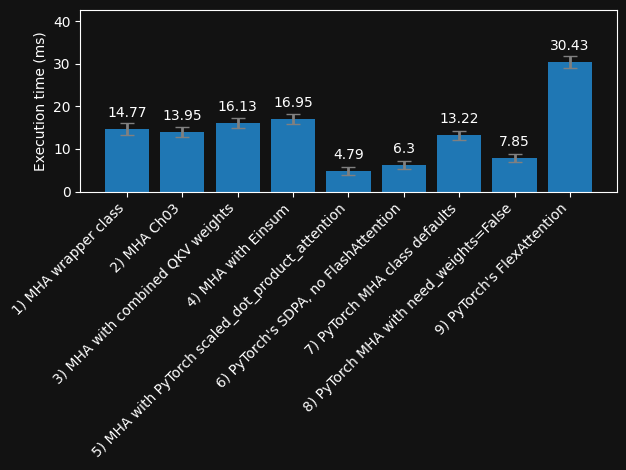

In [51]:
execution_stats = [time_pytorch_function(fn, embeddings) for fn in functions.values()]
execution_means = [stat[0] for stat in execution_stats]
execution_stds = [stat[1] for stat in execution_stats]


plot_execution_times(functions, execution_means, execution_stds, filename="1_forward-only.pdf")

### **Forward and Backward Passes**

In [54]:
def forward_backward(func, embeddings):
    if embeddings.grad is not None:
        embeddings.grad.zero_()

    output = func(embeddings)
    loss = output.sum()
    loss.backward()

def time_pytorch_function_forward_backward(func, *input, num_repeats = 1_000):
    # CUDA IS ASYNC so can't use python time module
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    # Warmup
    for _ in range(5):
        forward_backward(func, *input)
    torch.cuda.synchronize()

    times = []
    for _ in range(num_repeats):
        start.record()
        forward_backward(func, *input)
        end.record()
        torch.cuda.synchronize()
        times.append(start.elapsed_time(end))

    return np.mean(times), np.std(times)

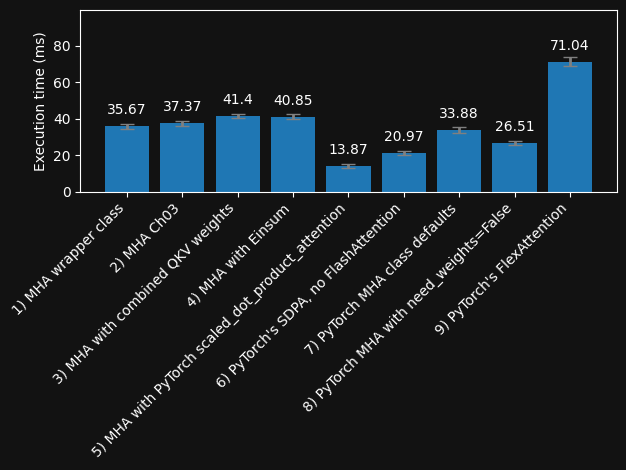

In [55]:
execution_stats = [time_pytorch_function_forward_backward(fn, embeddings) for fn in functions.values()]
execution_means = [stat[0] for stat in execution_stats]
execution_stds = [stat[1] for stat in execution_stats]


plot_execution_times(functions, execution_means, execution_stds, filename="2_forward-and-backward.pdf")